In [2]:
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline


In [4]:
# Загружаем файлы
files.upload()
!ls # Выводим содержимое корневой папки

Saving cars_new.csv to cars_new.csv
cars_new.csv  sample_data


In [5]:
# Считываем csv с помощью pandas
cars = pd.read_csv('cars_new.csv', sep=',')
cars[:5] # Выводим первые 5 машин 

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [6]:
print(cars.values.shape)

(70119, 10)


In [7]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [8]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [9]:
print(fuels_dict)

{'бензин': 0, 'электро': 1, 'гибрид': 2, 'дизель': 3, 'газ': 4}


In [10]:
volumes.mean()

1.2879530757014324e-16

In [11]:
volumes.std()

1.0

In [12]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [13]:
# Создаём пустую обучающую выборку
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])
  
  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]
  
  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [15]:
# Выводим размеры выборок
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [16]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[ 0.          0.          0.          0.          1.          0.
  0.          0.          1.          0.          0.          1.
  0.          0.          0.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [17]:
# Выводим y_train
print(y_train[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [18]:
y_train.shape

(70119,)

In [19]:
y_train.reshape(-1,1).shape

(70119, 1)

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)

In [30]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [31]:
StandardScaler

sklearn.preprocessing._data.StandardScaler

In [32]:
y_train_scaled.shape

(63107,)

In [33]:
# Выводим базовый и нормированный y_train
print(y_train[:10])
print(y_train_scaled[:10])

[ 160000.   95000.  550000.  265555.   60000.  440000. 1449000.  220000.
  579500.   50000.]
[-0.59914521 -0.70512376  0.03672611 -0.42704419 -0.76218914 -0.14262221
  1.50249103 -0.50131885  0.08482407 -0.77849353]


In [34]:
y_scaler.inverse_transform(y_train_scaled)

array([160000.,  95000., 550000., ..., 418000., 850000., 350000.])

Epoch 1/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2637 - val_loss: 0.1016
Epoch 2/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1522 - val_loss: 0.0786
Epoch 3/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1269 - val_loss: 0.0717
Epoch 4/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1099 - val_loss: 0.0649
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0948 - val_loss: 0.0618
Epoch 6/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0901 - val_loss: 0.0750
Epoch 7/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0846 - val_loss: 0.0585
Epoch 8/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0759 - val_loss: 0.0593
Epoch 9/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0734 - val_loss: 0.0588
Epoch 10/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.067

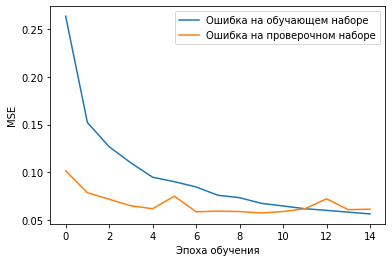

In [35]:
# Создаём сеть
model_ula = Sequential()
model_ula.add(Dense(1000, activation='relu', input_shape=(x_train.shape[1],)))
model_ula.add(Dropout(0.2))
model_ula.add(Dense(100, activation='relu'))
model_ula.add(Dense(1, activation='linear'))

model_ula.compile(optimizer=Adam(lr=0.0001), loss='mse')

# 50000 примеров будет в обучающей выборке
n_val = 50000
history = model_ula.fit(x_train[:n_val], 
                    y_train_scaled[:n_val],
                    batch_size=32,
                    epochs=15, 
                    validation_data=(x_train[n_val:], y_train_scaled[n_val:]), 
                    verbose=1)

# Отображаем графики ошибки обучения по обучающей выборке и по проверочной выборке на всех эпохах
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [36]:
# Предсказываем проверочную выборку
predict = model_ula.predict(x_test)
# Меняем масштаб обратно от нормированного к оригинальному
predict = y_scaler.inverse_transform(predict).flatten()

# Считаем среднюю цену, среднюю ошибку и средний процент ошибки
mean_delta = np.mean(abs(predict - y_test))
mean_price = np.mean(y_test)
print('Средняя ошибка: ', round(mean_delta))
print('Средняя цена: ', round(mean_price))
print('Суммарный процент ошибки: ', round(100*mean_delta/mean_price), '%', sep='')

Средняя ошибка:  72476.0
Средняя цена:  529989.0
Суммарный процент ошибки: 14.0%
